In [1]:
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import os
from IPython.display import Image
import tensorflow.keras.backend as K
import pandas as pd
import numpy as np
import seaborn as sns


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


True


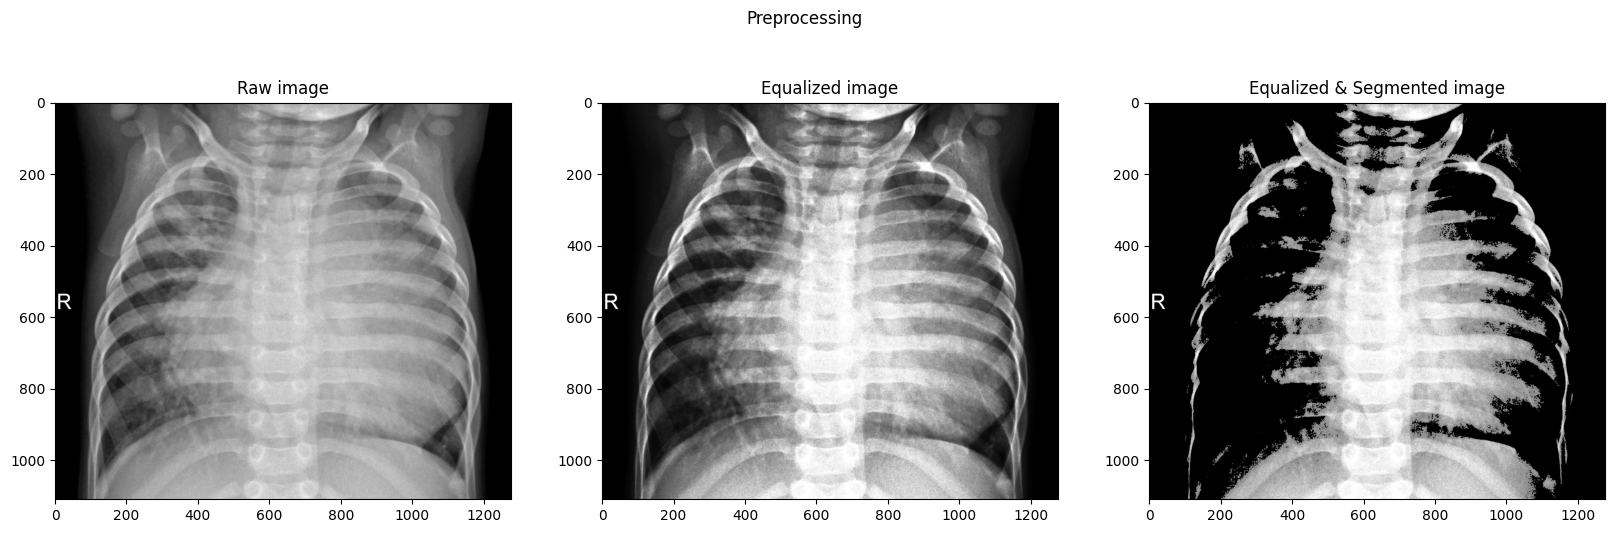

In [3]:
# Verify the file path
print(os.path.exists('/content/drive/MyDrive/ViemPhoi/pneumonia/person5_bacteria_15.jpeg'))

# Load the image using cv2.imread with the correct path and flag
img = cv2.imread('/content/drive/MyDrive/ViemPhoi/pneumonia/person5_bacteria_15.jpeg', cv2.IMREAD_GRAYSCALE)
# Check if the image was loaded successfully
if img is None:
    print("Error: Could not load image. Please check the file path and permissions.")
else:
    equalizedImage = cv2.equalizeHist(img)
    e, segmentedImage = cv2.threshold(equalizedImage, 128, 255, cv2.THRESH_TOZERO)

    plt.figure(figsize=(20, 6))

    ax1 = plt.subplot(1, 3, 1)
    plt.imshow(img, cmap='gray')  # Changed to display grayscale image
    ax1.set_title('Raw image')

    ax2 = plt.subplot(1, 3, 2)
    plt.imshow(equalizedImage, cmap='gray')  # Changed to display grayscale image
    ax2.set_title('Equalized image')

    ax3 = plt.subplot(1, 3, 3)
    plt.imshow(segmentedImage, cmap='gray')  # Changed to display grayscale image
    ax3.set_title('Equalized & Segmented image')

    plt.suptitle('Preprocessing')

    plt.show()

In [4]:
print(os.getcwd(), os.listdir())
DIR = '/content/drive/MyDrive/ViemPhoi'
CATS = ['pneumonia', 'normal']

DEST_DIR = './data2'

/content ['.config', 'drive', 'processedData', 'data2', 'sample_data']


In [5]:
print(os.getcwd(), os.listdir())

DIR = '/content/drive/MyDrive/ViemPhoi'
CATS = ['pneumonia', 'normal']

DEST_DIR = './data2'

if not os.path.exists(DEST_DIR):
    !mkdir data2 && cd data2 && mkdir pneumonia && mkdir non-pneumonia

for category in CATS:
    path = os.path.join(DIR, category)
    for image in os.listdir(path):
        curr = os.path.join(path, image)
        img = cv2.imread(curr, 0)
        equalizedImage = cv2.equalizeHist(img)
        e, segmentedImage = cv2.threshold(equalizedImage, 128, 255, cv2.THRESH_TOZERO)
        if category == 'normal':
            # Update the replacement path for imgDest
            imgDest = curr.replace('/content/drive/MyDrive/ViemPhoi/normal', 'data2/non-pneumonia')
            cv2.imwrite(imgDest, segmentedImage)
        else:
            # Update the replacement paths for imgDest
            imgDest = curr.replace('/content/drive/MyDrive/ViemPhoi/pneumonia', 'data2/pneumonia')
            imgDest = imgDest.replace('/content/drive/MyDrive/ViemPhoi/pneumonia', 'data2/pneumonia')
            cv2.imwrite(imgDest, segmentedImage)
print("Processed data directory created successfully at", DEST_DIR)

/content ['.config', 'drive', 'processedData', 'data2', 'sample_data']
Processed data directory created successfully at ./data2


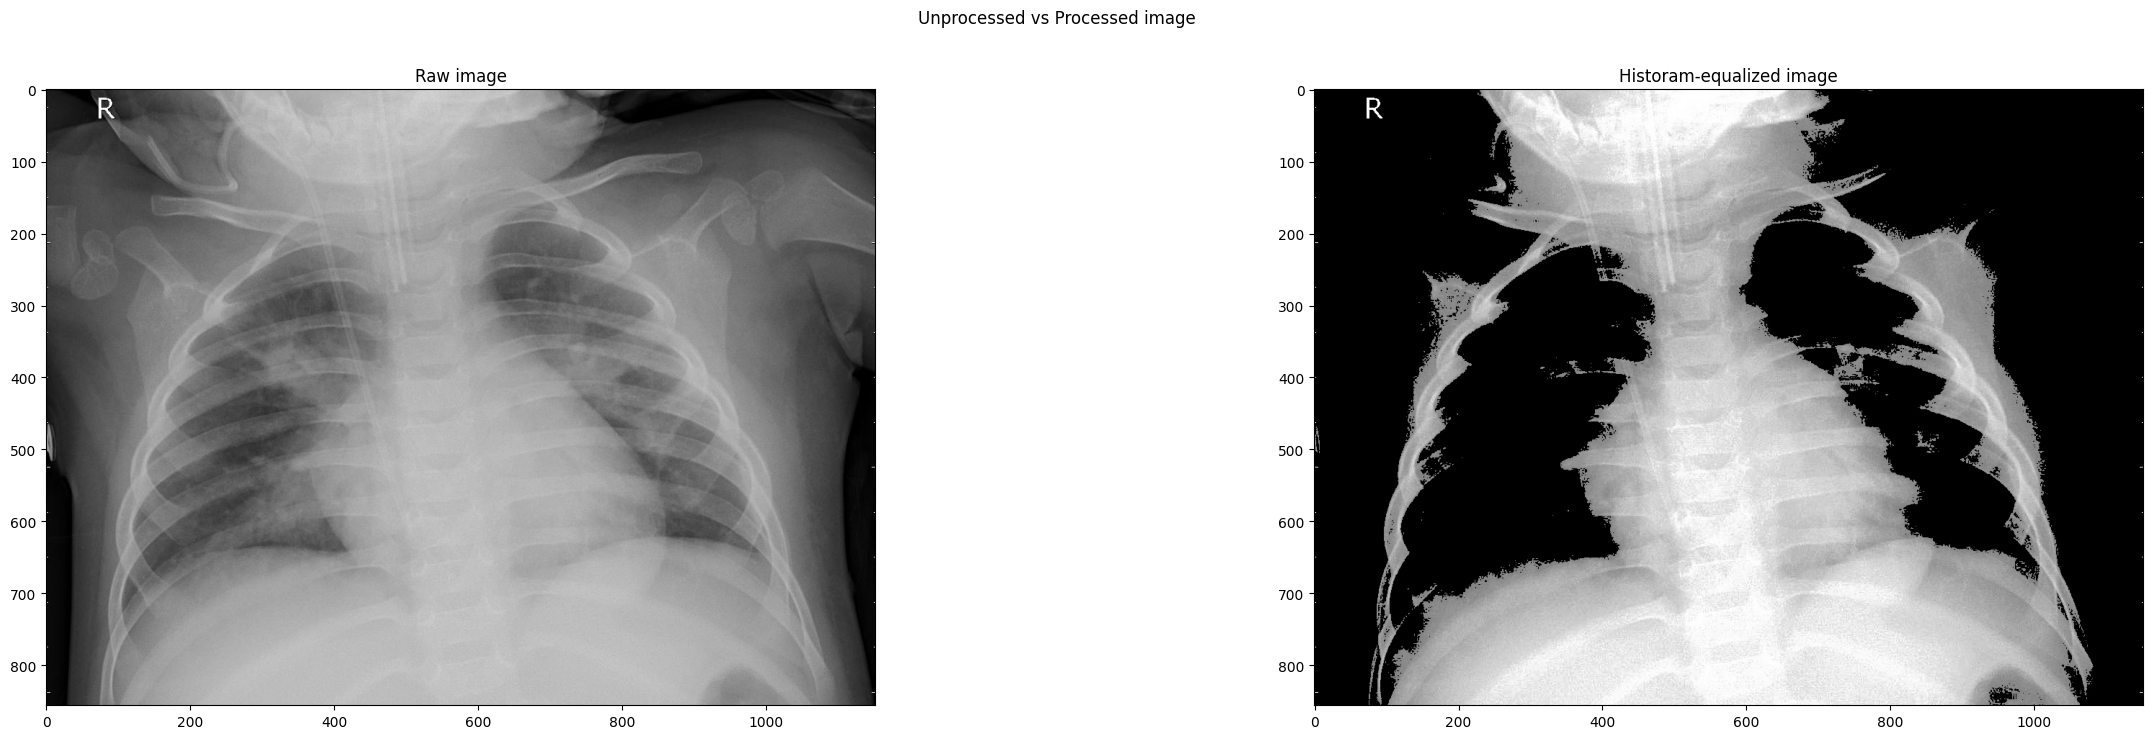

In [6]:
plt.figure(figsize=(30, 8))
plt.subplot(1, 2, 1)

# Load the image using cv2.imread with error handling
image_path = os.path.join(DIR, CATS[0], 'person9_bacteria_39.jpeg')
img = cv2.imread(image_path)

# Check if the image was loaded successfully
if img is None:
    print(f"Error: Could not load image from {image_path}. Please check the file path and permissions.")
else:
    plt.imshow(img)
    plt.title('Raw image')

plt.subplot(1, 2, 2)

# Load the processed image using cv2.imread with error handling
processed_image_path = os.path.join(DEST_DIR, 'pneumonia', 'person9_bacteria_39.jpeg')
processed_img = cv2.imread(processed_image_path)

# Check if the image was loaded successfully
if processed_img is None:
    print(f"Error: Could not load image from {processed_image_path}. Please check the file path and permissions.")
else:
    plt.imshow(processed_img)
    plt.title('Historam-equalized image')

plt.suptitle('Unprocessed vs Processed image')
plt.show()

In [7]:
!pip install split-folders
import splitfolders

FINAL_DIR = './processedData'

splitfolders.ratio(DEST_DIR, output=FINAL_DIR, seed=69420, ratio=(.7, 0.1,0.2))

Copying files: 4069 files [00:01, 2082.59 files/s]


In [8]:

BASE_DIR = './processedData'

# Constants
BATCH_SIZE = 32

# Data generators
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=5,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# Update paths to use local directories
train_dataset = train_datagen.flow_from_directory(
    directory=os.path.join(BASE_DIR, 'train'),
    target_size=(224, 224),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

valid_dataset = valid_datagen.flow_from_directory(
    directory=os.path.join(BASE_DIR, 'val'),
    target_size=(224, 224),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

test_dataset = test_datagen.flow_from_directory(
    directory=os.path.join(BASE_DIR, 'test'),
    target_size=(224, 224),
    class_mode='binary',
    batch_size=BATCH_SIZE
)


Found 2848 images belonging to 2 classes.
Found 406 images belonging to 2 classes.
Found 815 images belonging to 2 classes.


In [9]:
def F1(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='Accuracy'),
    tf.keras.metrics.Precision(name='Precision'),
    tf.keras.metrics.Recall(name='Recall'),
    tf.keras.metrics.AUC(name='AUC'),
    F1,
]

In [10]:
def plot_history(hist, name):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].plot(hist.history['Accuracy'])
    axs[0].plot(hist.history['val_Accuracy'])
    axs[0].set_title(f'{name} Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['train', 'val'], loc='upper left')

    axs[1].plot(hist.history['loss'])
    axs[1].plot(hist.history['val_loss'])
    axs[1].set_title(f'{name} Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'val'], loc='upper left')

    axs[2].plot(hist.history['Precision'])
    axs[2].plot(hist.history['val_Precision'])
    axs[2].set_title(f'{name} Precision')
    axs[2].set_ylabel('Precision')
    axs[2].set_xlabel('Epoch')
    axs[2].legend(['train', 'val'], loc='upper left')

    plt.show()

# Define your models here
def create_mobilenet():
    MOBILENET_base = tf.keras.applications.MobileNet(input_shape=(224,224,3), include_top=False)

    for layer in MOBILENET_base.layers:
        layer.trainable = False

    model = tf.keras.Sequential([
        MOBILENET_base,
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(32, kernel_initializer='he_uniform'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(32, kernel_initializer='he_uniform'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(32, kernel_initializer='he_uniform'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    return model


In [11]:
MOBILENET = create_mobilenet()

In [12]:
MOBILENET.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functi  (None, 7, 7, 1024)        3228864   
 onal)                                                           
                                                                 
 dropout (Dropout)           (None, 7, 7, 1024)        0         
                                                                 
 flatten (Flatten)           (None, 50176)             0         
                                                                 
 batch_normalization (Batch  (None, 50176)             200704    
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 32)                1605664   
                                                                 
 batch_normalization_1 (Bat  (None, 32)                1

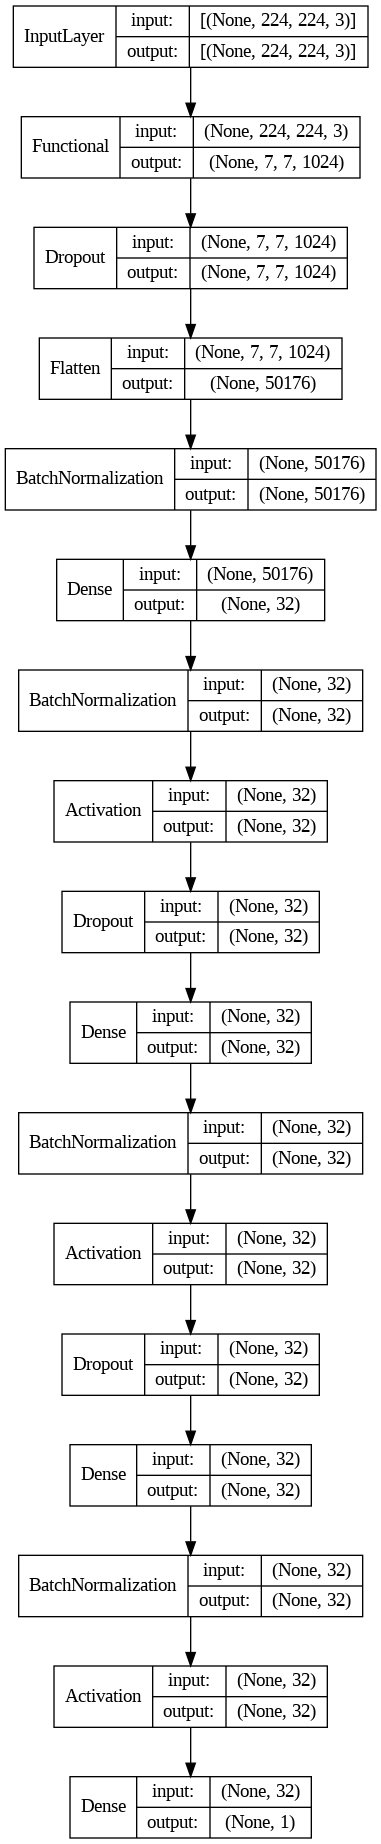

In [14]:
!pip install pydot
!pip install graphviz
# Import the necessary modules
from tensorflow.keras.utils import plot_model
from IPython.display import Image

# Plot model architecture
plot_model(MOBILENET, to_file='/MOBILENET.png', show_shapes=True, show_layer_names=False)
Image(filename='/MOBILENET.png')

In [15]:
MOBILENET.compile(optimizer='adam', loss='binary_crossentropy', metrics=METRICS)

In [16]:
lrd = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.5, min_lr=1e-7)
mcp = tf.keras.callbacks.ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_accuracy')
es = tf.keras.callbacks.EarlyStopping(verbose=1, patience=5)

In [17]:
eval_results = []

Training and evaluating MobileNet...
Epoch 1/10
89/89 [==============================] - ETA: 0s - loss: 0.5408 - Accuracy: 0.7496 - Precision: 0.8638 - Recall: 0.8165 - AUC: 0.7115 - F1: 0.8316

89/89 [==============================] - 61s 644ms/step - loss: 0.5408 - Accuracy: 0.7496 - Precision: 0.8638 - Recall: 0.8165 - AUC: 0.7115 - F1: 0.8316 - val_loss: 0.4483 - val_Accuracy: 0.8227 - val_Precision: 0.9922 - val_Recall: 0.7853 - val_AUC: 0.9831 - val_F1: 0.8782 - lr: 0.0010
Epoch 2/10
89/89 [==============================] - ETA: 0s - loss: 0.3487 - Accuracy: 0.8676 - Precision: 0.8853 - Recall: 0.9593 - AUC: 0.8702 - F1: 0.9198

89/89 [==============================] - 55s 619ms/step - loss: 0.3487 - Accuracy: 0.8676 - Precision: 0.8853 - Recall: 0.9593 - AUC: 0.8702 - F1: 0.9198 - val_loss: 0.2249 - val_Accuracy: 0.9384 - val_Precision: 0.9902 - val_Recall: 0.9325 - val_AUC: 0.9893 - val_F1: 0.9612 - lr: 0.0010
Epoch 3/10
89/89 [==============================] - ETA: 0s - loss: 0.2899 - Accuracy: 0.8817 - Precision: 0.8985 - Recall: 0.9610 - AUC: 0.9149 - F1: 0.9272

89/89 [==============================] - 55s 622ms/step - loss: 0.2899 - Accuracy: 0.8817 - Precision: 0.8985 - Recall: 0.9610 - AUC: 0.9149 - F1: 0.9272 - val_loss: 0.1828 - val_Accuracy: 0.9409 - val_Precision: 0.9935 - val_Recall: 0.9325 - val_AUC: 0.9914 - val_F1: 0.9622 - lr: 0.0010
Epoch 4/10
89/89 [==============================] - ETA: 0s - loss: 0.2572 - Accuracy: 0.8943 - Precision: 0.9182 - Recall: 0.9532 - AUC: 0.9366 - F1: 0.9344

89/89 [==============================] - 56s 626ms/step - loss: 0.2572 - Accuracy: 0.8943 - Precision: 0.9182 - Recall: 0.9532 - AUC: 0.9366 - F1: 0.9344 - val_loss: 0.1460 - val_Accuracy: 0.9532 - val_Precision: 0.9812 - val_Recall: 0.9601 - val_AUC: 0.9888 - val_F1: 0.9707 - lr: 0.0010
Epoch 5/10
89/89 [==============================] - ETA: 0s - loss: 0.2270 - Accuracy: 0.9066 - Precision: 0.9290 - Recall: 0.9567 - AUC: 0.9507 - F1: 0.9421

89/89 [==============================] - 56s 628ms/step - loss: 0.2270 - Accuracy: 0.9066 - Precision: 0.9290 - Recall: 0.9567 - AUC: 0.9507 - F1: 0.9421 - val_loss: 0.1269 - val_Accuracy: 0.9557 - val_Precision: 0.9783 - val_Recall: 0.9663 - val_AUC: 0.9890 - val_F1: 0.9709 - lr: 0.0010
Epoch 6/10
89/89 [==============================] - ETA: 0s - loss: 0.2220 - Accuracy: 0.9098 - Precision: 0.9374 - Recall: 0.9510 - AUC: 0.9529 - F1: 0.9437

89/89 [==============================] - 56s 628ms/step - loss: 0.2220 - Accuracy: 0.9098 - Precision: 0.9374 - Recall: 0.9510 - AUC: 0.9529 - F1: 0.9437 - val_loss: 0.1150 - val_Accuracy: 0.9655 - val_Precision: 0.9845 - val_Recall: 0.9724 - val_AUC: 0.9894 - val_F1: 0.9777 - lr: 0.0010
Epoch 7/10
89/89 [==============================] - ETA: 0s - loss: 0.2014 - Accuracy: 0.9161 - Precision: 0.9402 - Recall: 0.9562 - AUC: 0.9607 - F1: 0.9477

89/89 [==============================] - 55s 620ms/step - loss: 0.2014 - Accuracy: 0.9161 - Precision: 0.9402 - Recall: 0.9562 - AUC: 0.9607 - F1: 0.9477 - val_loss: 0.1148 - val_Accuracy: 0.9631 - val_Precision: 0.9844 - val_Recall: 0.9693 - val_AUC: 0.9877 - val_F1: 0.9760 - lr: 0.0010
Epoch 8/10
89/89 [==============================] - ETA: 0s - loss: 0.2089 - Accuracy: 0.9161 - Precision: 0.9424 - Recall: 0.9536 - AUC: 0.9542 - F1: 0.9471

89/89 [==============================] - 56s 624ms/step - loss: 0.2089 - Accuracy: 0.9161 - Precision: 0.9424 - Recall: 0.9536 - AUC: 0.9542 - F1: 0.9471 - val_loss: 0.1073 - val_Accuracy: 0.9655 - val_Precision: 0.9845 - val_Recall: 0.9724 - val_AUC: 0.9887 - val_F1: 0.9778 - lr: 0.0010
Epoch 9/10
89/89 [==============================] - ETA: 0s - loss: 0.2025 - Accuracy: 0.9175 - Precision: 0.9373 - Recall: 0.9615 - AUC: 0.9604 - F1: 0.9483

89/89 [==============================] - 56s 626ms/step - loss: 0.2025 - Accuracy: 0.9175 - Precision: 0.9373 - Recall: 0.9615 - AUC: 0.9604 - F1: 0.9483 - val_loss: 0.1125 - val_Accuracy: 0.9631 - val_Precision: 0.9785 - val_Recall: 0.9755 - val_AUC: 0.9876 - val_F1: 0.9754 - lr: 0.0010
Epoch 10/10
89/89 [==============================] - ETA: 0s - loss: 0.1790 - Accuracy: 0.9238 - Precision: 0.9531 - Recall: 0.9518 - AUC: 0.9704 - F1: 0.9521

26/26 [==============================] - 8s 295ms/step - loss: 0.0825 - Accuracy: 0.9730 - Precision: 0.9876 - Recall: 0.9786 - AUC: 0.9936 - F1: 0.9822


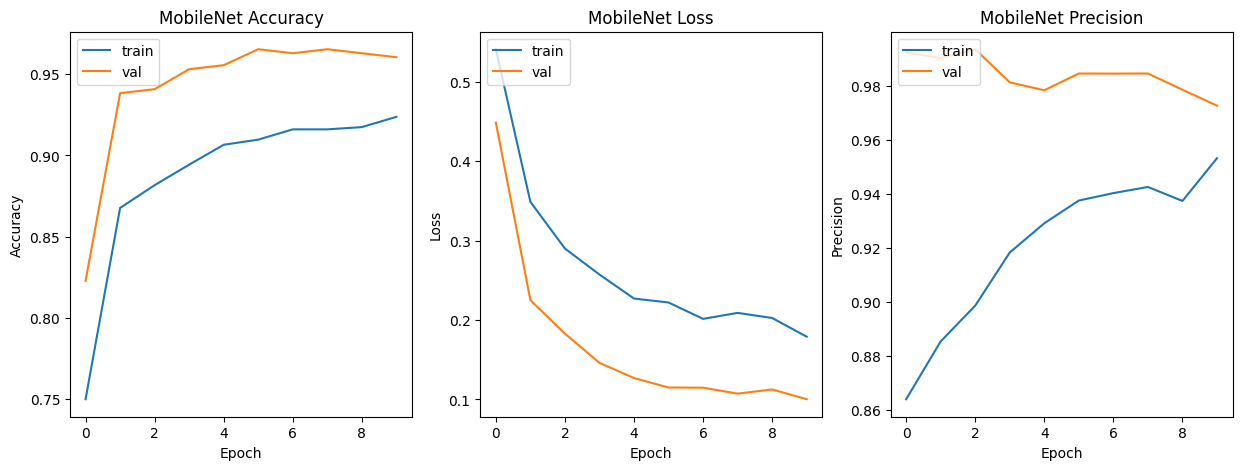

In [18]:
models = [MOBILENET]
model_names = ['MobileNet']

for model, name in zip(models, model_names):
    print(f"Training and evaluating {name}...")
    history = model.fit(
        train_dataset,
        validation_data=valid_dataset,
        epochs=10,
        verbose=1,
        callbacks=[lrd, mcp, es]
    )
    scores = model.evaluate(test_dataset, verbose=1)
    eval_results.append(scores)
    plot_history(history, name)

In [19]:
# Based on the model, predict some example images
def predict_multiple_images(image_paths, model):
    results = []
    for image_path in image_paths:
        img = cv2.imread(image_path)
        if img is None:
            print(f"Warning: Unable to read image at {image_path}")
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        img = cv2.resize(img, (224, 224))
        img = img / 255.0  # Normalize
        img = np.expand_dims(img, axis=0)  # Add batch dimension

        prediction = model.predict(img)
        label = "Pneumonia" if prediction[0][0] > 0.5 else "Non-Pneumonia"
        confidence = prediction[0][0] if label == "Pneumonia" else 1 - prediction[0][0]

        results.append((image_path, img[0], label, confidence))

    return results

1/1 [==============================] - 0s 40ms/step


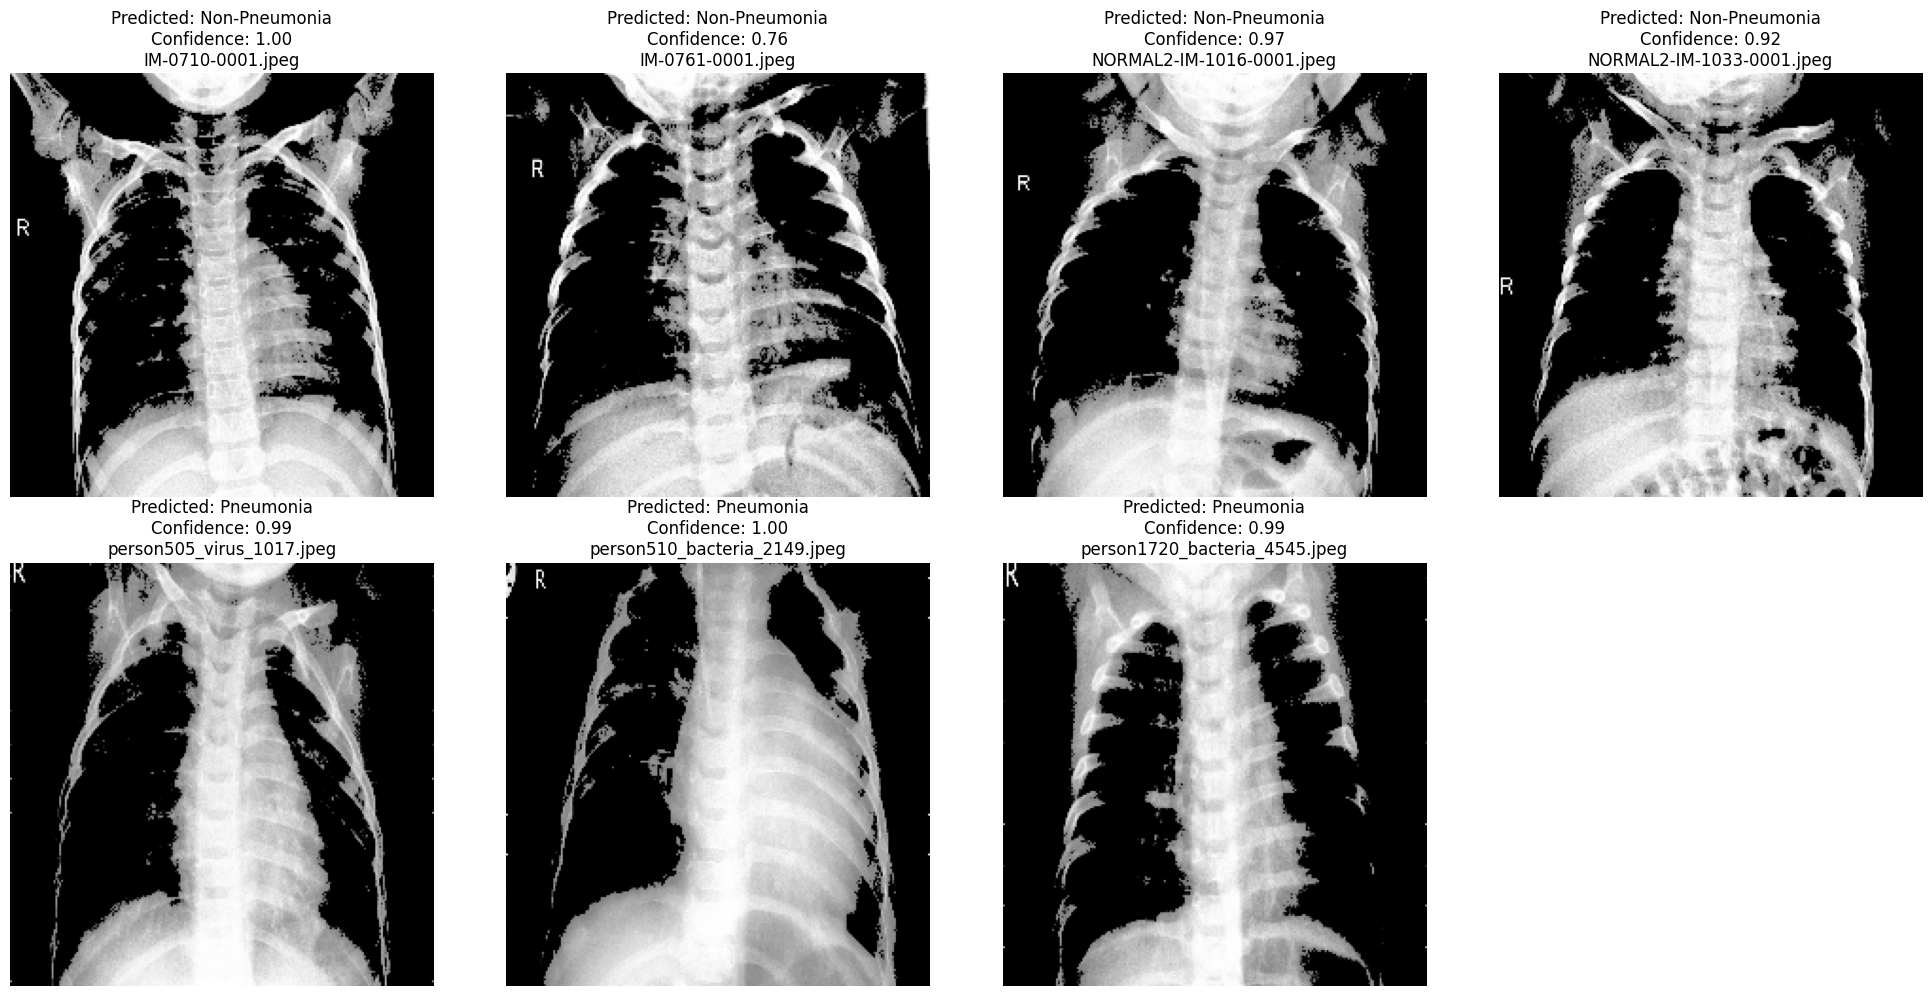

In [24]:
image_path = [
"/content/processedData/test/non-pneumonia/IM-0710-0001.jpeg",
"/content/processedData/test/non-pneumonia/IM-0761-0001.jpeg",
"/content/processedData/test/non-pneumonia/NORMAL2-IM-1016-0001.jpeg",
"/content/processedData/test/non-pneumonia/NORMAL2-IM-1033-0001.jpeg",
"/content/processedData/test/pneumonia/person505_virus_1017.jpeg",
"/content/processedData/test/pneumonia/person510_bacteria_2149.jpeg",
"/content/processedData/test/pneumonia/person1720_bacteria_4545.jpeg",

]


# Predict and visualize multiple images
predictions = predict_multiple_images(image_path, MOBILENET)

# Visualize the predictions
num_images = len(predictions)
rows = (num_images + 3) // 4
plt.figure(figsize=(20, 5 * rows))

for i, (image_path, img, label, confidence) in enumerate(predictions):
    ax = plt.subplot(rows, 4, i+1)
    plt.imshow(img)
    plt.title(f"Predicted: {label}\nConfidence: {confidence:.2f}\n{os.path.basename(image_path)}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [25]:
# Print predictions
for image_path, _, label, confidence in predictions:
    print(f"Prediction for image {os.path.basename(image_path)}:")
    print(f"Predicted Label: {label}")
    print(f"Confidence: {confidence:.2f}")
    print()

Prediction for image IM-0710-0001.jpeg:
Predicted Label: Non-Pneumonia
Confidence: 1.00

Prediction for image IM-0761-0001.jpeg:
Predicted Label: Non-Pneumonia
Confidence: 0.76

Prediction for image NORMAL2-IM-1016-0001.jpeg:
Predicted Label: Non-Pneumonia
Confidence: 0.97

Prediction for image NORMAL2-IM-1033-0001.jpeg:
Predicted Label: Non-Pneumonia
Confidence: 0.92

Prediction for image person505_virus_1017.jpeg:
Predicted Label: Pneumonia
Confidence: 0.99

Prediction for image person510_bacteria_2149.jpeg:
Predicted Label: Pneumonia
Confidence: 1.00

Prediction for image person1720_bacteria_4545.jpeg:
Predicted Label: Pneumonia
Confidence: 0.99

